In [2]:
# load libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [139]:
def get_info(summonername):
    # request html document from champions played webpage (current season only, default option)

    # for a given user name
    user = summonername

    # url formatting
    user = user.replace(" ", "%20")
    url = "https://euw.op.gg/summoners/euw/{}/champions".format(user)

    # make request and soup it
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(r.text, 'html.parser')

    # info extracting
    champion_list = soup.find(class_="content").find_all("tr")

    # get rid of table header
    champion_list = champion_list[1:]

    champion_info = []
    for champion in champion_list:
        # summoner name
        summoner_name = soup.find(class_="name").text
        # champion played
        champion_name = champion.find("img")['alt']
        # games won
        try:
            games_won = int(champion.find(class_="winratio-graph__text left").text.replace("W", ""))
        except:
            games_won = 0
        # games lost
        try:
            games_lost = int(champion.find(class_="winratio-graph__text right").text.replace("L", ""))
        except:
            games_lost = 0
        # games played
        games_played = games_won + games_lost
        # champion winrate
        champion_wr = games_won/games_played
        # kda
        try:
            kda = float(champion.find(class_="value").find_all("div")[1].text.replace(":1", ""))
        except:
            kda = 0
        # cs per minute
        cspm = champion.find_all(class_="value")[2].text
        cspm = cspm[cspm.find('(')+1:cspm.find(')')]

        champion_info.append([summoner_name, champion_name, games_played, champion_wr, kda, cspm])

    # create dataframe with champion info from a desired player
    champion_info = pd.DataFrame(champion_info, columns=["Summoner Name", "Champion", "Games Played", "Winrate", "KDA", "CS per minute"])

    # player info url
    url = "https://euw.op.gg/summoners/euw/{}".format(user)

    # make request and soup it
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    games_info = BeautifulSoup(r.text, 'html.parser').find(class_="css-164r41r exlvoq30").find_all(class_="css-ja2wlz e19epo2o3")[0:20]

    game_info = []
    for game in games_info:
        if game.find(class_="info").find(class_="type").text=="Ranked Solo":      
            # summoner name
            summoner_name = soup.find(class_="name").text
            # summoner winrate
            try:
                summoner_wr = int(BeautifulSoup(r.text, 'html.parser').find(class_="win-lose").text[-3:-1])/100
            except:
                summoner_wr = 0
            # game result
            try:
                result = int(game.find(class_="game-result").text.replace("Victory", "1").replace("Defeat", "0"))
            except ValueError:
                result = 99
            # champion name
            champion_name = game.find(class_="champion").find(class_="name").text
            
            game_info.append([summoner_name, summoner_wr, champion_name, result])


    games_df = pd.DataFrame(game_info, columns=["Summoner Name", "Summoner Winrate", "Champion", "Result"])

    # Winrate in last 10 games
    try:
        games_df["WinRate Last 5"] = sum(games_df['Result'][0:5])/len(games_df[0:5])
    except:
        games_df["WinRate Last 5"] = 0

    # Merge champion and player data
    merged_data = pd.merge(champion_info, games_df, on=["Summoner Name", "Champion"], how="right")

    return merged_data

In [183]:
name_list = []
page_count = 0

for page in range(660, 680):
    page_count += 1
    print("Page", str(page_count))
    # change url to new page
    url = "https://euw.op.gg/leaderboards/tier?page={}&region=euw".format(page)

    # requests html for each page
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(r.text, 'html.parser')

    raw_names = soup.find_all(class_="css-1xdhyk6 ei93w700")
    for name in raw_names:
        name_list.append(name.find("strong").text)


Page 1
Page 2
Page 3
Page 4
Page 5
Page 6
Page 7
Page 8
Page 9
Page 10
Page 11
Page 12
Page 13
Page 14
Page 15
Page 16
Page 17
Page 18
Page 19
Page 20


In [184]:
df = pd.DataFrame()
count = 0
for name in name_list:
    count += 1
    print("Players mined:", str(count), "/", str(len(name_list)))
    try:
        df = df.append(get_info(name))
    except AttributeError:
        pass

Players mined: 1 / 2000
Players mined: 2 / 2000
Players mined: 3 / 2000
Players mined: 4 / 2000
Players mined: 5 / 2000
Players mined: 6 / 2000
Players mined: 7 / 2000
Players mined: 8 / 2000
Players mined: 9 / 2000
Players mined: 10 / 2000
Players mined: 11 / 2000
Players mined: 12 / 2000
Players mined: 13 / 2000
Players mined: 14 / 2000
Players mined: 15 / 2000
Players mined: 16 / 2000
Players mined: 17 / 2000
Players mined: 18 / 2000
Players mined: 19 / 2000
Players mined: 20 / 2000
Players mined: 21 / 2000
Players mined: 22 / 2000
Players mined: 23 / 2000
Players mined: 24 / 2000
Players mined: 25 / 2000
Players mined: 26 / 2000
Players mined: 27 / 2000
Players mined: 28 / 2000
Players mined: 29 / 2000
Players mined: 30 / 2000
Players mined: 31 / 2000
Players mined: 32 / 2000
Players mined: 33 / 2000
Players mined: 34 / 2000
Players mined: 35 / 2000
Players mined: 36 / 2000
Players mined: 37 / 2000
Players mined: 38 / 2000
Players mined: 39 / 2000
Players mined: 40 / 2000
Players m

In [185]:
# save mining process
df.to_parquet("df1.parquet")

In [40]:
df = pd.read_parquet("df-FULL.parquet")

In [43]:
# Análisis Nulos por columnas
nulos_col = pd.merge(df.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/df.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
5,Games Played,6887,float64,0.036715
6,Winrate,6887,float64,0.036715
7,KDA,6887,float64,0.036715
8,CS per minute,6887,float64,0.036715
0,Summoner Name,0,object,0.000000
1,Champion,0,object,0.000000
2,Summoner Winrate,0,float64,0.000000
4,WinRate Last 5,0,float64,0.000000
3,Result,0,int32,0.000000


In [42]:
df['Result'] = df['Result'].astype('int')
df['CS per minute'] = df['CS per minute'].astype('float')

df = df.loc[df['Result'] != 99]

In [46]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

In [45]:
import lightgbm
from sklearn.model_selection import train_test_split
from aux_func import evaluate_model, model_analysis

#Combining numerical and categorical piepline into one big pipeline horizontally using ColumnTransformer
from sklearn.compose import ColumnTransformer

## No podemos utilizar TransformTargetRegression porque estamos en un modelo de clasificacion
# from 'Y' and 'N' to numeric values
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [66]:
#Defining the steps in the numerical pipeline 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))])

#Defining the steps in the categorical pipeline 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    
#Numerical features to pass down the numerical pipeline 
numeric_features = df.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).drop(['Result'], axis=1).columns

#Categrical features to pass down the categorical pipeline 
categorical_features = df.drop(["Summoner Name"], axis=1).select_dtypes(include=['object']).columns

In [70]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

classifiers = [
    lightgbm.LGBMClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

In [71]:
x, y = df.drop(["Summoner Name", "Result"], axis=1), df['Result']
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=0)

In [72]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(xtrain, ytrain)   
    print(classifier)
    print("model score: %.3f" % pipe.score(xtest, ytest))

LGBMClassifier()
model score: 0.638
DecisionTreeClassifier()
model score: 0.549


KeyboardInterrupt: 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import re
import matplotlib

In [30]:
evaluate_model(ytest, ypred, ypred_proba)

ROC-AUC score of the model: 0.7028163928556785
Accuracy of the model: 0.6379241410560545

Classification report: 
              precision    recall  f1-score   support

           0       0.65      0.55      0.59     18069
           1       0.63      0.72      0.67     19448

    accuracy                           0.64     37517
   macro avg       0.64      0.63      0.63     37517
weighted avg       0.64      0.64      0.64     37517


Confusion matrix: 
[[ 9918  8151]
 [ 5433 14015]]



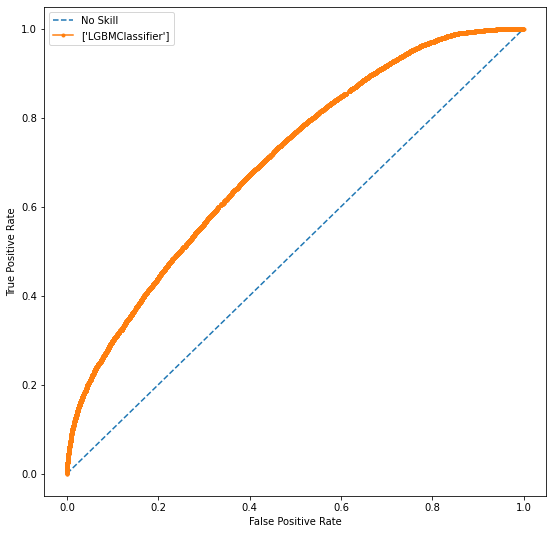

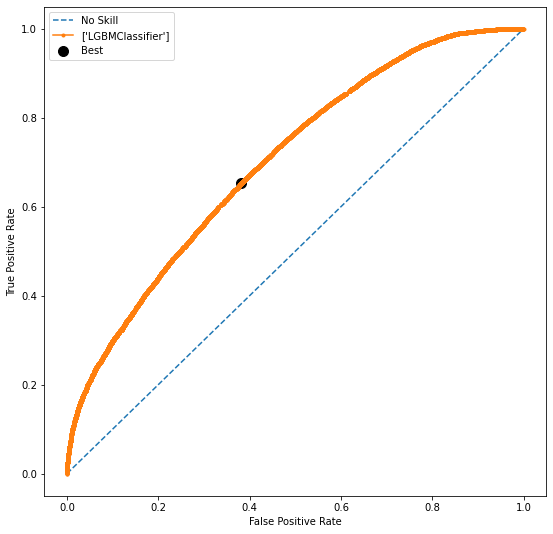

ROC-AUC score of the model: 0.7028163928556785
Accuracy of the model: 0.6365114481435082

Classification report: 
              precision    recall  f1-score   support

           0       0.62      0.62      0.62     18069
           1       0.65      0.65      0.65     19448

    accuracy                           0.64     37517
   macro avg       0.64      0.64      0.64     37517
weighted avg       0.64      0.64      0.64     37517


Confusion matrix: 
[[11175  6894]
 [ 6743 12705]]



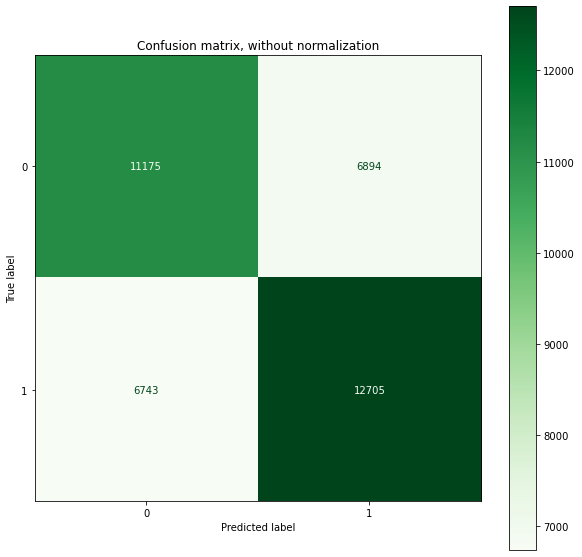

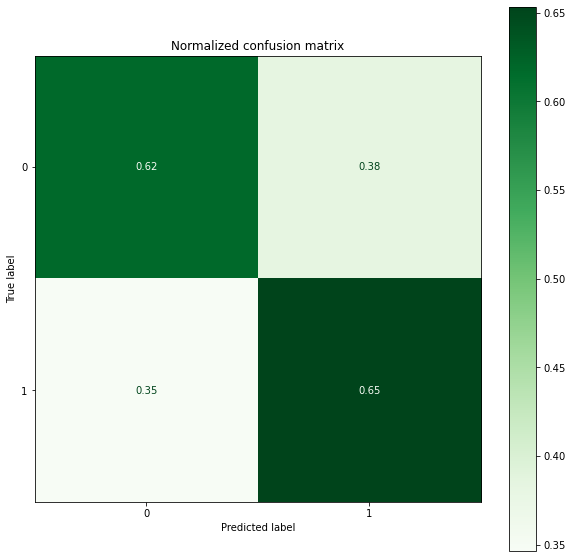

In [31]:
model_analysis(model, xtest, ytest)

In [32]:
df["KDA"].boxplot()

AttributeError: 'Series' object has no attribute 'boxplot'

In [37]:
import numpy as np
import matplotlib.pyplot as plt

np.median(df["KDA"].dropna())

2.62